

# **Text Classification with Universal Language Models**

In this challenge, I chose to utilize the Universal Language Model Fine-tuning for Text Classification (ULMFiT) approach to tacke a real-world problem, which is the US airlines sentiment analysis. The dataset, available on Kaggle, encompasses the lsit of tweets forumulated by individual who have had experiences with six different U.S. airlines. The tweets were then classified into three different cateogires: positive, neutral and negative. The goal is to predict, based on a variety of techniques, in which category a non-labeled tweet belongs to. 

Full approach here: http://nlp.fast.ai/classification/2018/05/15/introducting-ulmfit.html

Basically, based on the ULMFIT approach, in order to do text classification on English tweets, the model needed to understand basic English first. Therefore, training a model to try to predict the next words of a sentence forumulated in English was a mandatory first step. This technique is called Language Model.

Here, the approach was segmented in three steps: 


1.   Using a pre-trained model to train a new model (Transfer Learning). In details, using a model trained on English Wiki text, which can reasonably understand English by attempting to predict the next words in an English sentence (with about 30% accuracy); 
2.   Adapt the new trained model to English tweets - so the model can understand them;
3. Classify the tweets into three different categories: positive, negative and neutral. 







# Dataset

The dataset, available here: https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv, is a .csv file, with 15 differenr columns and 14.5k rows.


# Library

Implementing a research paper in which Jeremy Howard was involved, there's no better library than FastAi. The library offers a high-level 'pythonist' experience, as it is built on top of PyTorch, another Deep Learning Framework. The module fastai.text is all what is required to classify texts. 

In [ ]:
from fastai.text import *
import seaborn as sns
from matplotlib.pyplot import figure
from google.colab import drive
from wordcloud import WordCloud,STOPWORDS

In addition to the FastAi Library, I needed to import a few more libraries, mostly in charge of the visual aspects of the dataset, such as Matplotlib and Seaborn. 


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls "/content/drive/My Drive/twitter-airline-sentiment"

biden.json             data_save.pkl  models/                Tweets.csv
biden_predictions.csv  export.pkl     trump.csv
database.sqlite        ici.csv        trump.json
data_lm.pkl            ici.gsheet     trump_predictions.csv


In [ ]:
ls "/content/drive/My Drive/Colab Notebooks"

'Copy of Embedding ULMFiT.ipynb'   Untitled12.ipynb   Untitled5.ipynb
'Embedding ULMFiT.ipynb'           Untitled13.ipynb   Untitled6.ipynb
'Multilabel_heavy (1).ipynb'       Untitled1.ipynb    Untitled7.ipynb
 Untitled0.ipynb                   Untitled2.ipynb    Untitled8.ipynb
 Untitled10.ipynb                  Untitled3.ipynb    Untitled9.ipynb
 Untitled11.ipynb                  Untitled4.ipynb    Untitled.ipynb


Using Google Colab, I needed to upload the dataset in the cloud; I chose Google Drive. 

In [ ]:
path = Path("/content/drive/My Drive/twitter-airline-sentiment/") ; path

PosixPath('/content/drive/My Drive/twitter-airline-sentiment')

There it is: 

In [ ]:
df = pd.read_csv(path/'Tweets.csv', parse_dates=['tweet_created']) ; df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


Using the Pandas Library to read the .csv file and then, convert it to a Pandas DataFrame, a data structure extremly easy to manipulate. More info here: https://pandas.pydata.org/


In [ ]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

We have indeed 15 columns, as described on Kaggle.

In [ ]:
df['text'][0]

'@VirginAmerica What @dhepburn said.'

Here, I grabbed the first element of the 'text' column to see how the tweets look like

In [ ]:
df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [ ]:
print("% of null/na values")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

% of null/na values


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

It would make sense to delete the three columns which have a very high percentage of missing data.

In [ ]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


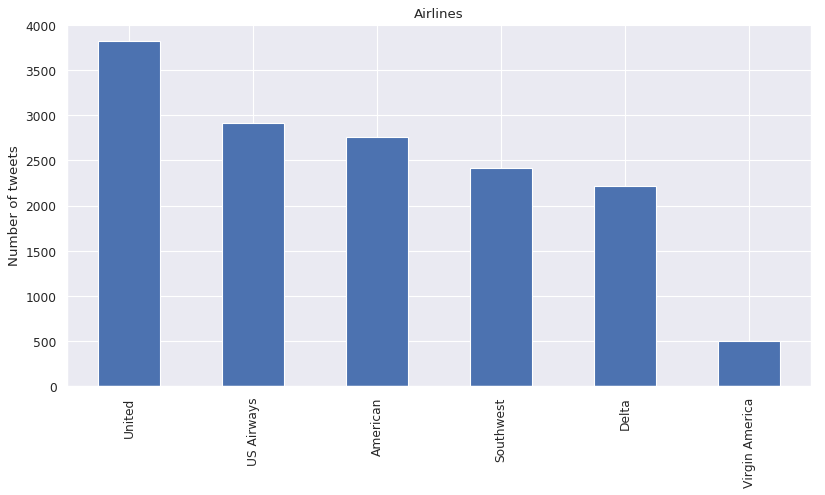

In [ ]:
sns.set()
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Airlines')
plt.ylabel('Number of tweets')
df.airline.value_counts().plot.bar()

Using Matplotlib to see which airline generated more tweets (positive, neutral and negative). It seems that we have a winner: United Airlines.

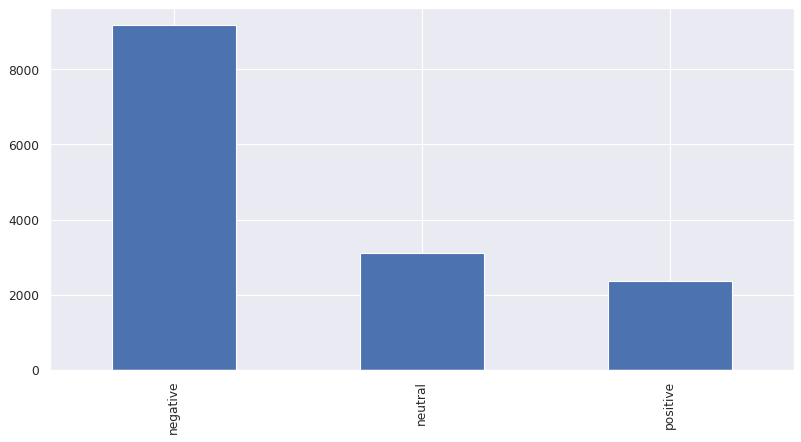

In [ ]:
sns.set()
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
df.airline_sentiment.value_counts().plot.bar()

It's also clear that the number of negative tweets is extremly high. It indicates that people are less likely to talk about good experiences.

In [ ]:
df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False)

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64

<Figure size 960x960 with 0 Axes>

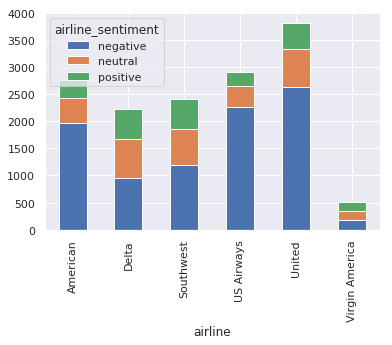

In [ ]:
sns.set()
figure(num=None, figsize=(12, 12), dpi=80, facecolor='b', edgecolor='y')
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

It seems that Delta has a good reatio, compared to, for instance, US Airways. Virgin America has a balanced ratio too, but it has apparently less traffic. United, on the other hand, seems to provide quite unpleasant experiences to travelers.

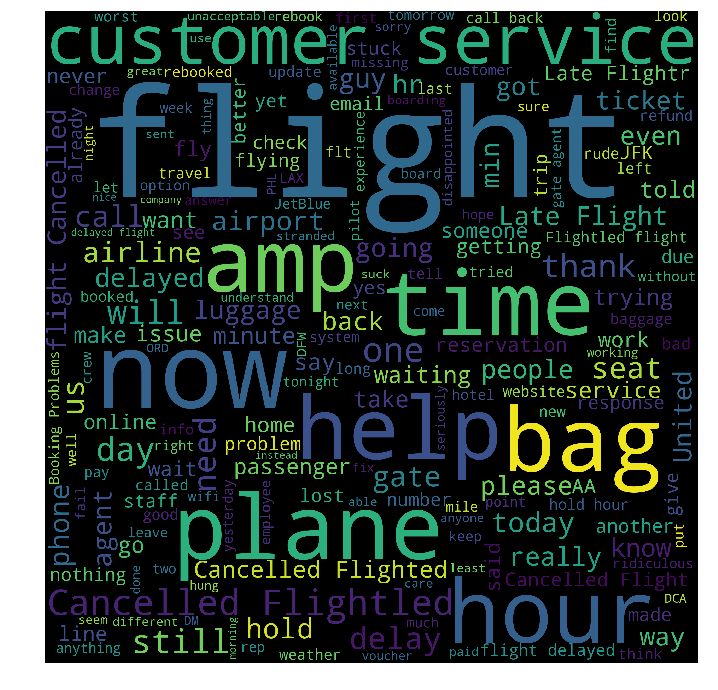

In [ ]:
df_neg=df[df['airline_sentiment']=='negative']
words = ' '.join(df_neg['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=2500,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


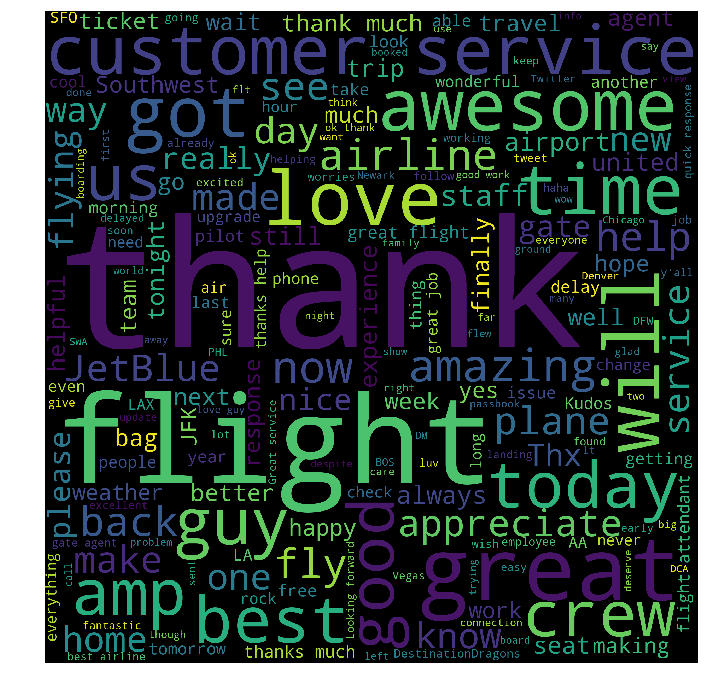

In [ ]:
df_pos=df[df['airline_sentiment']=='positive']
words = ' '.join(df_pos['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=2500,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#  Universal Language Model Fine-tuning for Text Classification (ULMFiT) 

Finally comes the fun part: sentiment analysis using ULMFiT.

In [ ]:
data = TextDataBunch.from_csv(path, 'Tweets.csv', text_cols='text', label_cols='airline_sentiment', valid_pct=0.1) 

Here, I created a data object using the TextDataBunch class, which can take any kind of DataLoader class and Dataset class,  provided a path to the dataset, the name of the .csv file (since I utilized the method .from_csv), defined the column which represents the text that we are about to analyze, and kept 10% of the dataset for evaluation. 

TextDataBunch converts the text to numbers so we can throw them in a neural net, the process is called 'Numericalization'. However, in order to numericalize text, we need first to 'clean' them, using the 'Tokenization' technique.

In [ ]:
data.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj xxunk xxmaj like u xxmaj in xxmaj future !,positive
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @usairways xxup fuk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup overpriced xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup fuk u xxup and,negative


When we display a batch, we can see that the texts have ben altered, or tokenized. Jeremy Howard explained what Tokenization basically meant: 

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch. 

In [ ]:
learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.5)

Next step is to create a Learner. An object from the RNNLearner CLass, which takes a DataBunch (data), a module (AWD_LSTM) with multi-drop-outs (embedding dropout, input dropout, weight dropout and hiddenm dropout). Jeremy Howard said he would explain those concepts further in the part II of his course.

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


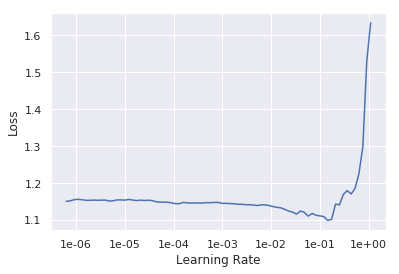

In [ ]:
learn.recorder.plot()

The plot helps us identify the optimal learning rate: here, it's approx. in between 1e-02 and 1e-01.

In [ ]:
%time learn.fit_one_cycle(3, (1e-02+1e-01)/2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.958522,0.927133,0.629352,00:06
1,0.888510,0.928055,0.629352,00:06
2,0.910761,0.899651,0.629352,00:06


CPU times: user 13.3 s, sys: 5.56 s, total: 18.8 s
Wall time: 19.5 s


After that we fit the model and indicate the number of epochs, the learning rate and we optimize it by calling the momentum param.

In [ ]:
learn.save("first_try")

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(((1e-02+1e-01)/4)/(2.6**4),(1e-02+1e-01)/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.936007,7.142032,0.575427,00:08
1,0.855625,0.828734,0.636860,00:07


In [ ]:
learn.save('second')

Then, progressively, we 'unfreeze' some of the last layers, to modify the weights a little bit.

In [ ]:
learn.unfreeze()
%time learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.683871,0.580128,0.772014,00:18
1,0.555713,0.501384,0.804096,00:19
2,0.489899,0.491063,0.807509,00:17


CPU times: user 33.4 s, sys: 20.2 s, total: 53.6 s
Wall time: 55.5 s


Eventually, we obtained an accuracy score of 80.5%.

In [ ]:
learn.save('fourth')

In [ ]:
learn.predict('awesome')

(Category positive, tensor(2), tensor([1.1504e-04, 2.4790e-02, 9.7509e-01]))

In [ ]:
learn.export()

In [ ]:
import pickle
pickle.dump(learn, open('models/final_prediction.pickle', 'wb'))

IsADirectoryError: ignored

Awesome is indeed something positive.

# Behind the Scene

Now, let's see what's going on behind the scene.

# **Tokenization**

The first step as I mentioned is to 'Tokenize' the text. It consists basically of separating each word, of segmenting them and then, of categorizing them. The limit is to keep only 6000 words, which were at least mentionned twice. This is called the vocab.

In [ ]:
len(data.vocab.itos[:])

5880

The model kept 5880 words.

In [ ]:
data.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'to',
 'i',
 'the',
 '!',
 '?',
 'a',
 'you',
 '/',
 ',',
 'flight']

Here is our vocab. It looks weird but it is necessary. For instance, 'xxunk' replaces the words which were 'uknown' or hard to identify for our model.

In [ ]:
data.train_ds[0][0]

Text xxbos @usairways please help ! xxmaj no bags , no way to get through to customer service since xxup 8am this morning ! xxmaj help ! !

A tokenized tweet would like like that.

# Numericalization


In [ ]:
data.train_ds[0][0].data[:]

array([   2,   26,   96,   69,   13,    5,   44,  172,   18,   44,  136,   10,   49,  213,   10,   74,   63,  248,
          6, 4099,   48,  271,   13,    5,   69,   13,   13])

Then, we numericalize our words, by assigning numbers to each word, so we can use them in a neural network.

# **Language model**

Now, let's focus on the language model. The model consists of predicting the next English words in a sentence, to make sure that the model understood English.

We will go through the same procedure as previously. 

In [ ]:
data_lm = TextLMDataBunch.from_csv(path, 'Tweets.csv', text_cols=['text'])

In [ ]:
data_lm.show_batch()

idx,text
0,"you won me over ! xxbos @jetblue i am less concerned about the delay than i am about not being notified until i looked at the board that my flight was delayed xxbos @southwestair xxmaj please explain to reps , ignoring a technical issue and passing the xxunk is not a good business model . xxmaj lucky limited to 140 xxbos @usairways would love it if you could get my"
1,xxbos @southwestair i consider myself a loyal customer to the brand but i 'm xxunk at the lack of concern about customer 's flying experiences . xxbos @usairways you should get better employees ✌ ️ xxbos @united had a different fiasco on my xxunk trip and was rebooked on to qantas lax - xxmaj xxunk . xxmaj no xxup ff miles show up in my account for that :( xxbos
2,"much ! ! xxmaj you say you care but i now see not so much ! xxmaj right now , you suck ! ! xxbos @usairways xxmaj huge system problems at xxunk check in ; flight boarded but sitting at gate due to system issues . xxmaj frustrated xxmaj chairman member xxbos @southwestair thanks for taking it up a notch ! ! xxunk # xxunk # xxunk @ xxmaj norfolk"
3,today the same flight is half that ! xxmaj is there any way for me to get that discount ? ? xxbos @jetblue you are doing a horrible job at xxup jfk ... you need to xxunk how you put these routes together . xxmaj unprofessional xxbos @usairways we should have been given the option to get off the plane not sit on it for a time longer than our
4,this awful weather it appears i can get home xxbos @americanair xxmaj trying to find out if flight # 340 xxup dfw to xxup hou is on tonight . xxmaj exec platinum desk not calling back and online info not clear . xxbos @southwestair flying flight 3130 tonight at 7:20 from xxup pbi- i have boarding position xxup c-42 . xxmaj is flight overbooked ? xxmaj have funeral to attend


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


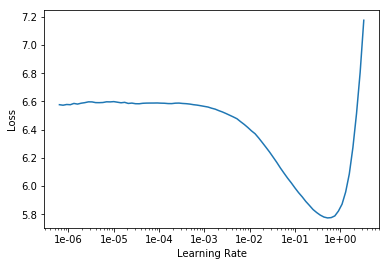

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.715494,4.060605,0.249595,00:10


In [ ]:
learn.save('first_lm')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(4, 1e-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.946559,3.808755,0.278516,00:13
1,3.750785,3.681691,0.295731,00:13
2,3.516718,3.656018,0.298535,00:14
3,3.318762,3.666696,0.298354,00:14


In [ ]:
learn.save('fine_tuned')

The model is now able to predict the next English word in a sentence with 30& accuracy. Not bad at all. Let's test it:

In [ ]:
TEXT = "I missed my flight because"
N_WORDS = 15
N_SENTENCES = 4

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I missed my flight because of your " lack of response " and the " lack of communication " we
I missed my flight because my flight was Cancelled Flightled . Help ! xxbos @southwestair Unable
I missed my flight because of your DM . Really ? xxbos @americanair What is the reason
I missed my flight because of your poor communication . Appreciate it . xxbos @united i have .


That looks quite good. Based on the 'I missed my flight' sentence, the model generated a continuity of the sentence, which doesn't look bad at all.

# Thoughts

The ULMFiT approach proved to be reliable. With transfer learning, we gain time and efficiency. The FastAi library is also formidable. Allowing us to train complex models in a few lines of code. As proved here, we obtained an accuracy score of 80.5% with very limited hyperparameter tuning. Analyzing tweets is not an easy task, as they are not formulated in plain English, as sometimes the vocabulary and the spelling are poor and as the use of hashtags can confuse the model. However, under those circumstances, the model did a quite good job. I believe that the next steps would be to find a way to make the RNNs understand humour, sarcasm, irony...etc. 